Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


293/293 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6207 - loss: 0.9415 - val_accuracy: 0.6569 - val_loss: 0.8092 - learning_rate: 0.0010
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7088 - loss: 0.6771 - val_accuracy: 0.7857 - val_loss: 0.5450 - learning_rate: 0.0010
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8464 - loss: 0.4196 - val_accuracy: 0.8096 - val_loss: 0.5135 - learning_rate: 0.0010
Epoch 4/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8975 - loss: 0.3000 - val_accuracy: 0.7985 - val_loss: 0.5669 - learning_rate: 0.0010
Epoch 5/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9225 - loss: 0.2286 - val_accuracy: 0.7981 - val_loss: 0.5857 - learning_rate: 0.0010
Epoch 6/50
289/293 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9452 - loss: 0.1709
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9452 - loss: 0.1712 - val_ac

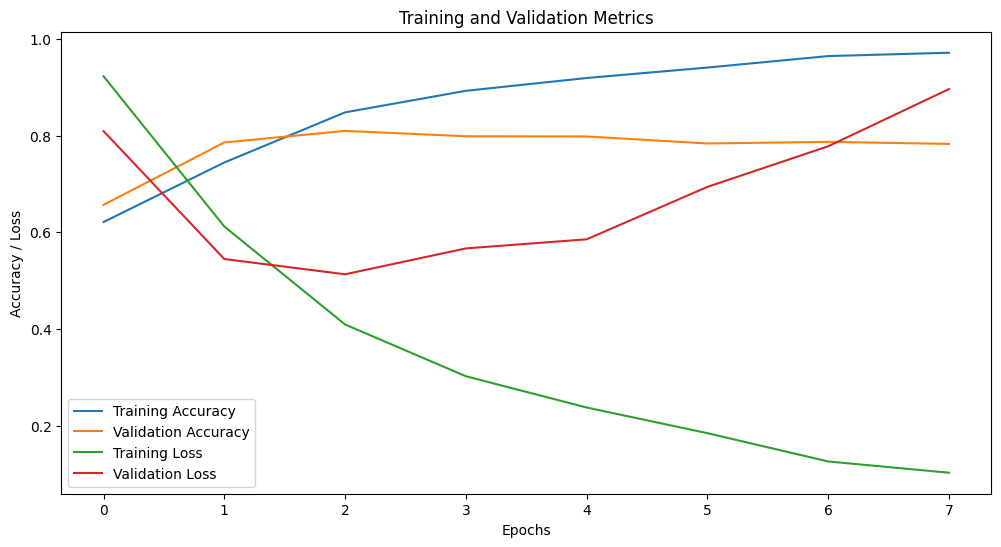

In [4]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, Embedding, LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Load dataset
file_path = '/kaggle/input/twitter-us-airline/Twitter_US_Airline/Tweets.csv'  # Replace with your dataset path
data = pd.read_csv(file_path)

# Data preprocessing
data = data[['text', 'airline_sentiment']].dropna()  # Keep relevant columns and remove nulls
label_encoder = LabelEncoder()
data['sentiment_encoded'] = label_encoder.fit_transform(data['airline_sentiment'])  # Encode sentiments

# Tokenization and padding
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, 
    data['sentiment_encoded'], 
    test_size=0.2, 
    random_state=42
)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define Attention Layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(1,), initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(score, axis=1)

        # Compute context vector
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

# Define the model
inputs = Input(shape=(max_len,))
embedding = Embedding(input_dim=max_words, output_dim=128, input_length=max_len)(inputs)
lstm_out = LSTM(128, return_sequences=True)(embedding)
attention = Attention()(lstm_out)
dense1 = Dense(64, activation='relu')(attention)
dropout = Dropout(0.3)(dense1)
outputs = Dense(3, activation='softmax')(dropout)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,  # Increased number of epochs
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {accuracy:.2f}')

# Save the model
model.save('attention_lstm_sentiment_analysis.h5')

# Visualize training performance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.show()
